In [1]:
from __future__ import division, print_function, absolute_import

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("data/", one_hot=False)

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import mnist as mn
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
from keras import backend as K
K.set_image_dim_ordering('th')

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Using TensorFlow backend.


In [2]:
# Training Parameters
learning_rate = 0.01
num_steps = 500
batch_size = 128
n_images = 10000

# Network Parameters
num_input = 784 # MNIST data input (img shape: 28*28)
num_classes = 10 # MNIST total classes (0-9 digits)
dropout = 0.25 # Dropout, probability to drop a unit

In [3]:
# Create the neural network
def conv_net(x_dict, n_classes, dropout, reuse, is_training):
    
    # Define a scope for reusing the variables
    with tf.variable_scope('ConvNet', reuse=reuse):
        # TF Estimator input is a dict, in case of multiple inputs
        x = x_dict['images']

        # MNIST data input is a 1-D vector of 784 features (28*28 pixels)
        # Reshape to match picture format [Height x Width x Channel]
        # Tensor input become 4-D: [Batch Size, Height, Width, Channel]
        x = tf.reshape(x, shape=[-1, 28, 28, 1])

        # Convolution Layer with 32 filters 
        conv1 = tf.layers.conv2d(x, 32, 5, activation=tf.nn.relu)

        # Convolution Layer with 64 filters 
        conv2 = tf.layers.conv2d(conv1, 64, 3, activation=tf.nn.relu)

        # Flatten the data to a 1-D vector for the fully connected layer
        fc1 = tf.contrib.layers.flatten(conv2)

        # Fully connected layer (in tf contrib folder for now)
        fc1 = tf.layers.dense(fc1, 1024)
        # Apply Dropout (if is_training is False, dropout is not applied)
        fc1 = tf.layers.dropout(fc1, rate=dropout, training=is_training)

        # Output layer, class prediction
        out = tf.layers.dense(fc1, n_classes)

    return out


In [4]:
# Define the model function (following TF Estimator Template)
def model_fn(features, labels, mode):
    
    # Build the neural network
    # Because Dropout have different behavior at training and prediction time, we
    # need to create 2 distinct computation graphs that still share the same weights.
    logits_train = conv_net(features, num_classes, dropout, reuse=False, is_training=True)
    logits_test = conv_net(features, num_classes, dropout, reuse=True, is_training=False)
    
    # Predictions
    pred_classes = tf.argmax(logits_test, axis=1)
    pred_probas = tf.nn.softmax(logits_test)
    
    # If prediction mode, early return
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=pred_classes) 
        
    # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits_train, labels=tf.cast(labels, dtype=tf.int32)))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op, global_step=tf.train.get_global_step())
    
    # Evaluate the accuracy of the model
    acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)
    
    # TF Estimators requires to return a EstimatorSpec, that specify
    # the different ops for training, evaluating, ...
    estim_specs = tf.estimator.EstimatorSpec(
      mode=mode,
      predictions=pred_classes,
      loss=loss_op,
      train_op=train_op,
      eval_metric_ops={'accuracy': acc_op})

    return estim_specs

In [5]:
# Build the Estimator
model = tf.estimator.Estimator(model_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpfas0q_gy', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1c49c4b6d8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [6]:
# Define the input function for training
X_tr={'images': mnist.train.images}
Y_tr=mnist.train.labels
input_fn = tf.estimator.inputs.numpy_input_fn(
    x=X_tr, y=Y_tr,
    batch_size=batch_size, num_epochs=None, shuffle=True)
# Train the Model
model.train(input_fn, steps=num_steps)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpfas0q_gy/model.ckpt.
INFO:tensorflow:loss = 2.3220022, step = 1
INFO:tensorflow:global_step/sec: 1.79515
INFO:tensorflow:loss = 0.6671036, step = 101 (55.707 sec)
INFO:tensorflow:global_step/sec: 1.30096
INFO:tensorflow:loss = 0.5303277, step = 201 (76.872 sec)
INFO:tensorflow:global_step/sec: 1.29576
INFO:tensorflow:loss = 0.5548632, step = 301 (77.169 sec)
INFO:tensorflow:global_step/sec: 1.28075
INFO:tensorflow:loss = 0.45887983, step = 401 (78.079 sec)
INFO:tensorflow:Saving checkpoints for 500 into /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpfas0q_gy/model.ckpt.
INFO:tensorflow:Loss for final step: 0.41344854.


In [7]:
# Evaluate the Model
# Define the input function for evaluating
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': mnist.test.images}, y=mnist.test.labels,
    batch_size=batch_size, shuffle=False)
# Use the Estimator 'evaluate' method
model.evaluate(input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-11-28-07:02:13
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpfas0q_gy/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-11-28-07:02:32
INFO:tensorflow:Saving dict for global step 500: accuracy = 0.8087, global_step = 500, loss = 0.528471
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 500: /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpfas0q_gy/model.ckpt-500


{'accuracy': 0.8087, 'loss': 0.528471, 'global_step': 500}

In [8]:
write = 1
if write==1:
    f = open("results/sheer.txt", 'w')

# Predict single images
# Get images from test set
test_images = mnist.test.images[:n_images]
test_label=mnist.test.labels[:n_images]

# # reshape to be [samples][pixels][width][height]
X_test = test_images
y_test = test_label
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)
# # convert from int to float
X_test = X_test.astype('float32')

X_test_backup = X_test
Y_test_backup = y_test

yBackup = []
pBackup = []
accMat = []


In [9]:
sheer = 0.0
for s in range(0,500):
    X_test = X_test_backup
    y_test = Y_test_backup
    
    datagen = ImageDataGenerator(shear_range=sheer)# fit parameters from data
    datagen.fit(X_test)
    tmp = []
    # configure batch size and retrieve one batch of images
    for X_batch, y_batch in datagen.flow(X_test, y_test, batch_size=n_images):
        tmp = X_batch
        yTemp = y_batch
        break
    X_test = tmp
    y_test = yTemp

    x_te={'images': tmp}
    input_fn = tf.estimator.inputs.numpy_input_fn(
        x=x_te, shuffle=False)
    # Use the model to predict the images class
    preds = list(model.predict(input_fn))
    accuracy = 0.0
    # Display
    for i in range(n_images):
        if (preds[i] == y_test[i]):
                accuracy = accuracy + 1/n_images
#         plt.imshow(np.reshape(tmp[i], [28, 28]), cmap='gray')
#         plt.show()
#         print("Model prediction:", preds[i])
    print("Model accuracy:", accuracy)
    yBackup.append(y_test)
    pBackup.append(preds)
    accMat.append(accuracy)
    if write==1:
        f.write(str(sheer)+"\t"+str(accuracy)+"\n")
    
    sheer = sheer+0.5
if write==1:    
    f.close()
print("Done!")

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpfas0q_gy/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.8086999999999273
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpfas0q_gy/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.8086999999999273
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpfas0q_gy/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_o

INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.7805999999999303
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpfas0q_gy/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.7811999999999303
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpfas0q_gy/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.7767999999999308
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpfas0q_gy/model.ckpt-500
I

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.7102999999999381
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpfas0q_gy/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.7137999999999377
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpfas0q_gy/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.7105999999999381
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.6419999999999456
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpfas0q_gy/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.638799999999946
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpfas0q_gy/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.6353999999999463
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6j

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.5824999999999522
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpfas0q_gy/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.583699999999952
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpfas0q_gy/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.5704999999999535
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6j

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.5224999999999588
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpfas0q_gy/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.5219999999999588
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpfas0q_gy/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.5189999999999592
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.47379999999996414
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpfas0q_gy/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.4757999999999639
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpfas0q_gy/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.4729999999999642
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf

INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpfas0q_gy/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.4279999999999692
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpfas0q_gy/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.4278999999999692
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpfas0q_gy/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.42449999999996957
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpfas0q_gy/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.3967999999999726
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpfas0q_gy/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.39269999999997307
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpfas0q_gy/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.36929999999997565
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpfas0q_gy/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.37009999999997556
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpfas0q_gy/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.3726999999999753
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2y

INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpfas0q_gy/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.35219999999997753
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpfas0q_gy/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.3490999999999779
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpfas0q_gy/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.35579999999997713
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_f

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpfas0q_gy/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.3333999999999796
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpfas0q_gy/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.33579999999997934
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpfas0q_gy/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.3416999999999787
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpfas0q_gy/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.33209999999997974
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpfas0q_gy/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.32739999999998026
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2y

INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpfas0q_gy/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.3315999999999798
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpfas0q_gy/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.33039999999997993
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpfas0q_gy/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.32469999999998056
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_f

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpfas0q_gy/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.33209999999997974
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpfas0q_gy/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.338699999999979
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpfas0q_gy/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_o

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.33729999999997917
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpfas0q_gy/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.3395999999999789
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpfas0q_gy/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.338699999999979
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6

INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpfas0q_gy/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.34389999999997845
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpfas0q_gy/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.3485999999999779
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpfas0q_gy/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.348099999999978
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpfas0q_gy/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.34829999999997796
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpfas0q_gy/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.3415999999999787
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpfas0q_gy/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.3459999999999782
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpfas0q_gy/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.347999999999978
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpfas0q_gy/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.3413999999999787
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6j

INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpfas0q_gy/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.3442999999999784
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpfas0q_gy/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.3379999999999791
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpfas0q_gy/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.33929999999997895
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpfas0q_gy/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.33859999999997903
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpfas0q_gy/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.3358999999999793
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpfas0q_gy/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.3216999999999809
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpfas0q_gy/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.3334999999999796
Done!


In [10]:
yTotal = [0]*10

for y in y_test:
    yTotal[y] = yTotal[y]+1

aMatrix = []
for i in range(len(pBackup)):
    print("\n\nYmatrix for rotation %d"%(i))
    yMatrix = [[0]*10 for i in range(10)]
    for j in range(len(pBackup[i])):
        yMatrix[yBackup[i][j]][pBackup[i][j]] += 1

    sum = 0
    
    for x in range(len(yMatrix)):
        for y in range(len(yMatrix[x])):
            yMatrix[x][y] = round(yMatrix[x][y]/yTotal[x], 3)

    aMatrix.append(yMatrix)
    for x in yMatrix:
        for y in x:
            print("%f" % (y),end=" ")
        print()
    



Ymatrix for rotation 0
0.696000 0.023000 0.030000 0.056000 0.004000 0.002000 0.169000 0.000000 0.020000 0.000000 
0.002000 0.970000 0.001000 0.018000 0.005000 0.000000 0.003000 0.000000 0.001000 0.000000 
0.011000 0.003000 0.777000 0.014000 0.084000 0.000000 0.101000 0.000000 0.010000 0.000000 
0.009000 0.033000 0.013000 0.873000 0.032000 0.002000 0.031000 0.000000 0.007000 0.000000 
0.002000 0.013000 0.232000 0.047000 0.578000 0.001000 0.122000 0.000000 0.005000 0.000000 
0.000000 0.000000 0.000000 0.000000 0.000000 0.987000 0.000000 0.011000 0.000000 0.002000 
0.124000 0.010000 0.197000 0.046000 0.082000 0.001000 0.514000 0.000000 0.026000 0.000000 
0.000000 0.001000 0.000000 0.000000 0.000000 0.075000 0.000000 0.915000 0.001000 0.008000 
0.001000 0.001000 0.016000 0.009000 0.006000 0.010000 0.017000 0.003000 0.936000 0.001000 
0.001000 0.000000 0.000000 0.001000 0.000000 0.040000 0.000000 0.117000 0.000000 0.841000 


Ymatrix for rotation 1
0.700000 0.023000 0.028000 0.056000 0.00

0.001000 0.000000 0.000000 0.001000 0.000000 0.040000 0.000000 0.107000 0.000000 0.851000 


Ymatrix for rotation 15
0.729000 0.020000 0.026000 0.049000 0.004000 0.002000 0.152000 0.000000 0.018000 0.000000 
0.002000 0.969000 0.001000 0.020000 0.003000 0.000000 0.004000 0.000000 0.001000 0.000000 
0.013000 0.003000 0.788000 0.013000 0.072000 0.000000 0.102000 0.000000 0.009000 0.000000 
0.009000 0.034000 0.015000 0.872000 0.030000 0.001000 0.034000 0.000000 0.005000 0.000000 
0.002000 0.015000 0.327000 0.047000 0.504000 0.001000 0.100000 0.000000 0.004000 0.000000 
0.000000 0.000000 0.000000 0.001000 0.000000 0.982000 0.000000 0.011000 0.005000 0.001000 
0.151000 0.010000 0.298000 0.041000 0.068000 0.000000 0.408000 0.000000 0.024000 0.000000 
0.000000 0.000000 0.000000 0.000000 0.000000 0.082000 0.000000 0.901000 0.006000 0.011000 
0.001000 0.001000 0.017000 0.008000 0.005000 0.006000 0.017000 0.003000 0.941000 0.001000 
0.001000 0.000000 0.000000 0.001000 0.000000 0.034000 0.000000 0

0.717000 0.019000 0.027000 0.036000 0.004000 0.002000 0.176000 0.000000 0.019000 0.000000 
0.002000 0.968000 0.001000 0.020000 0.004000 0.000000 0.004000 0.000000 0.001000 0.000000 
0.014000 0.003000 0.706000 0.012000 0.100000 0.000000 0.150000 0.000000 0.015000 0.000000 
0.011000 0.032000 0.009000 0.859000 0.029000 0.000000 0.055000 0.000000 0.005000 0.000000 
0.002000 0.017000 0.335000 0.054000 0.495000 0.003000 0.084000 0.000000 0.010000 0.000000 
0.000000 0.000000 0.000000 0.002000 0.000000 0.966000 0.000000 0.015000 0.015000 0.002000 
0.140000 0.012000 0.309000 0.034000 0.092000 0.000000 0.382000 0.000000 0.031000 0.000000 
0.000000 0.000000 0.000000 0.000000 0.000000 0.114000 0.000000 0.843000 0.032000 0.011000 
0.001000 0.003000 0.021000 0.007000 0.005000 0.005000 0.016000 0.003000 0.938000 0.001000 
0.001000 0.000000 0.000000 0.001000 0.000000 0.063000 0.000000 0.120000 0.000000 0.815000 


Ymatrix for rotation 30
0.702000 0.021000 0.020000 0.042000 0.005000 0.001000 0.189000 0

0.002000 0.968000 0.000000 0.018000 0.004000 0.000000 0.007000 0.000000 0.001000 0.000000 
0.009000 0.002000 0.622000 0.005000 0.138000 0.001000 0.186000 0.000000 0.037000 0.000000 
0.006000 0.034000 0.021000 0.806000 0.034000 0.000000 0.093000 0.000000 0.006000 0.000000 
0.002000 0.011000 0.333000 0.046000 0.502000 0.000000 0.087000 0.000000 0.019000 0.000000 
0.000000 0.000000 0.000000 0.003000 0.000000 0.954000 0.000000 0.013000 0.024000 0.006000 
0.122000 0.009000 0.329000 0.029000 0.113000 0.001000 0.354000 0.000000 0.043000 0.000000 
0.000000 0.000000 0.000000 0.000000 0.000000 0.192000 0.000000 0.698000 0.102000 0.008000 
0.001000 0.002000 0.012000 0.006000 0.004000 0.016000 0.027000 0.003000 0.927000 0.002000 
0.001000 0.000000 0.000000 0.000000 0.000000 0.092000 0.000000 0.145000 0.006000 0.756000 


Ymatrix for rotation 44
0.649000 0.015000 0.028000 0.037000 0.005000 0.003000 0.236000 0.000000 0.027000 0.000000 
0.002000 0.965000 0.001000 0.020000 0.005000 0.000000 0.005000 0

0.013000 0.027000 0.031000 0.789000 0.034000 0.000000 0.099000 0.000000 0.007000 0.000000 
0.002000 0.006000 0.358000 0.042000 0.474000 0.001000 0.089000 0.000000 0.028000 0.000000 
0.000000 0.000000 0.000000 0.002000 0.000000 0.936000 0.000000 0.014000 0.040000 0.008000 
0.114000 0.010000 0.330000 0.028000 0.137000 0.000000 0.325000 0.000000 0.055000 0.001000 
0.000000 0.000000 0.000000 0.000000 0.000000 0.229000 0.000000 0.597000 0.161000 0.013000 
0.000000 0.001000 0.015000 0.006000 0.005000 0.043000 0.026000 0.010000 0.889000 0.005000 
0.001000 0.000000 0.000000 0.001000 0.000000 0.161000 0.002000 0.136000 0.012000 0.687000 


Ymatrix for rotation 58
0.570000 0.014000 0.042000 0.035000 0.029000 0.004000 0.282000 0.000000 0.024000 0.000000 
0.002000 0.966000 0.002000 0.019000 0.002000 0.000000 0.008000 0.000000 0.001000 0.000000 
0.010000 0.001000 0.622000 0.006000 0.152000 0.000000 0.164000 0.000000 0.045000 0.000000 
0.013000 0.028000 0.028000 0.800000 0.030000 0.000000 0.097000 0

0.001000 0.011000 0.332000 0.047000 0.443000 0.001000 0.088000 0.000000 0.077000 0.000000 
0.000000 0.000000 0.000000 0.003000 0.001000 0.895000 0.000000 0.015000 0.079000 0.007000 
0.096000 0.008000 0.283000 0.031000 0.170000 0.001000 0.329000 0.001000 0.079000 0.002000 
0.000000 0.000000 0.000000 0.000000 0.000000 0.275000 0.000000 0.514000 0.205000 0.006000 
0.001000 0.001000 0.015000 0.008000 0.008000 0.050000 0.018000 0.019000 0.875000 0.005000 
0.000000 0.000000 0.000000 0.001000 0.000000 0.204000 0.002000 0.138000 0.037000 0.618000 


Ymatrix for rotation 72
0.463000 0.014000 0.061000 0.032000 0.056000 0.005000 0.339000 0.000000 0.030000 0.000000 
0.002000 0.960000 0.002000 0.020000 0.005000 0.000000 0.009000 0.000000 0.002000 0.000000 
0.008000 0.002000 0.560000 0.008000 0.157000 0.000000 0.157000 0.000000 0.107000 0.001000 
0.026000 0.031000 0.046000 0.733000 0.046000 0.000000 0.113000 0.000000 0.005000 0.000000 
0.000000 0.013000 0.343000 0.042000 0.450000 0.002000 0.085000 0

0.094000 0.006000 0.286000 0.029000 0.174000 0.001000 0.292000 0.001000 0.116000 0.001000 
0.000000 0.000000 0.000000 0.000000 0.000000 0.298000 0.000000 0.450000 0.244000 0.008000 
0.000000 0.002000 0.012000 0.013000 0.006000 0.075000 0.014000 0.028000 0.842000 0.008000 
0.001000 0.000000 0.000000 0.001000 0.004000 0.223000 0.001000 0.132000 0.080000 0.558000 


Ymatrix for rotation 86
0.393000 0.007000 0.086000 0.035000 0.077000 0.005000 0.361000 0.000000 0.036000 0.000000 
0.003000 0.956000 0.001000 0.020000 0.005000 0.001000 0.013000 0.000000 0.001000 0.000000 
0.006000 0.002000 0.497000 0.005000 0.165000 0.000000 0.186000 0.000000 0.139000 0.000000 
0.036000 0.035000 0.056000 0.692000 0.036000 0.000000 0.134000 0.000000 0.011000 0.000000 
0.002000 0.008000 0.315000 0.035000 0.435000 0.002000 0.092000 0.000000 0.111000 0.000000 
0.000000 0.002000 0.000000 0.003000 0.001000 0.883000 0.002000 0.011000 0.092000 0.006000 
0.086000 0.009000 0.286000 0.027000 0.158000 0.001000 0.320000 0

0.000000 0.001000 0.000000 0.000000 0.000000 0.325000 0.000000 0.376000 0.286000 0.012000 
0.001000 0.000000 0.016000 0.008000 0.012000 0.080000 0.019000 0.039000 0.813000 0.012000 
0.000000 0.000000 0.001000 0.000000 0.010000 0.230000 0.001000 0.143000 0.122000 0.493000 


Ymatrix for rotation 100
0.329000 0.011000 0.104000 0.033000 0.081000 0.007000 0.385000 0.000000 0.050000 0.000000 
0.000000 0.944000 0.006000 0.025000 0.004000 0.000000 0.018000 0.000000 0.003000 0.000000 
0.009000 0.004000 0.442000 0.004000 0.178000 0.001000 0.198000 0.000000 0.163000 0.001000 
0.041000 0.025000 0.049000 0.627000 0.056000 0.000000 0.187000 0.000000 0.015000 0.000000 
0.001000 0.007000 0.291000 0.046000 0.393000 0.005000 0.112000 0.000000 0.144000 0.001000 
0.000000 0.001000 0.000000 0.007000 0.000000 0.853000 0.004000 0.020000 0.109000 0.006000 
0.088000 0.007000 0.237000 0.029000 0.166000 0.003000 0.314000 0.001000 0.154000 0.001000 
0.000000 0.000000 0.000000 0.000000 0.000000 0.321000 0.000000 

0.000000 0.000000 0.000000 0.001000 0.011000 0.247000 0.002000 0.116000 0.166000 0.457000 


Ymatrix for rotation 114
0.324000 0.005000 0.090000 0.027000 0.082000 0.004000 0.382000 0.003000 0.082000 0.001000 
0.002000 0.909000 0.010000 0.030000 0.003000 0.002000 0.034000 0.000000 0.010000 0.000000 
0.007000 0.005000 0.430000 0.013000 0.160000 0.002000 0.196000 0.000000 0.185000 0.002000 
0.034000 0.024000 0.048000 0.579000 0.063000 0.000000 0.225000 0.001000 0.026000 0.000000 
0.002000 0.008000 0.290000 0.043000 0.401000 0.004000 0.104000 0.000000 0.147000 0.001000 
0.000000 0.003000 0.000000 0.009000 0.000000 0.840000 0.004000 0.017000 0.125000 0.002000 
0.058000 0.008000 0.218000 0.039000 0.161000 0.001000 0.316000 0.003000 0.193000 0.003000 
0.000000 0.001000 0.000000 0.000000 0.000000 0.380000 0.000000 0.315000 0.294000 0.010000 
0.000000 0.001000 0.013000 0.013000 0.007000 0.112000 0.017000 0.029000 0.805000 0.003000 
0.000000 0.000000 0.000000 0.000000 0.008000 0.241000 0.001000 

0.262000 0.005000 0.098000 0.027000 0.078000 0.003000 0.411000 0.001000 0.114000 0.001000 
0.004000 0.875000 0.016000 0.032000 0.004000 0.007000 0.048000 0.000000 0.014000 0.000000 
0.007000 0.003000 0.419000 0.014000 0.156000 0.003000 0.200000 0.000000 0.195000 0.003000 
0.024000 0.019000 0.054000 0.513000 0.069000 0.001000 0.272000 0.003000 0.045000 0.000000 
0.001000 0.005000 0.249000 0.041000 0.399000 0.002000 0.125000 0.000000 0.175000 0.003000 
0.000000 0.002000 0.003000 0.004000 0.001000 0.826000 0.005000 0.010000 0.143000 0.006000 
0.054000 0.009000 0.209000 0.026000 0.158000 0.005000 0.298000 0.003000 0.237000 0.001000 
0.000000 0.000000 0.000000 0.000000 0.000000 0.373000 0.000000 0.288000 0.333000 0.006000 
0.000000 0.000000 0.014000 0.012000 0.014000 0.112000 0.011000 0.037000 0.782000 0.018000 
0.002000 0.000000 0.000000 0.001000 0.017000 0.259000 0.001000 0.096000 0.193000 0.431000 


Ymatrix for rotation 129
0.261000 0.006000 0.107000 0.026000 0.076000 0.005000 0.390000 

0.008000 0.004000 0.382000 0.015000 0.143000 0.003000 0.211000 0.001000 0.233000 0.000000 
0.023000 0.017000 0.064000 0.473000 0.056000 0.001000 0.269000 0.002000 0.095000 0.000000 
0.003000 0.007000 0.261000 0.045000 0.377000 0.004000 0.147000 0.000000 0.154000 0.002000 
0.000000 0.004000 0.002000 0.011000 0.000000 0.806000 0.005000 0.012000 0.158000 0.002000 
0.033000 0.006000 0.210000 0.029000 0.173000 0.007000 0.299000 0.006000 0.235000 0.002000 
0.000000 0.000000 0.000000 0.000000 0.000000 0.407000 0.000000 0.259000 0.326000 0.008000 
0.002000 0.001000 0.008000 0.012000 0.010000 0.137000 0.018000 0.036000 0.763000 0.013000 
0.000000 0.000000 0.002000 0.001000 0.011000 0.279000 0.002000 0.093000 0.218000 0.394000 


Ymatrix for rotation 143
0.241000 0.010000 0.091000 0.029000 0.081000 0.007000 0.374000 0.002000 0.163000 0.002000 
0.004000 0.829000 0.026000 0.017000 0.002000 0.022000 0.069000 0.000000 0.031000 0.000000 
0.010000 0.004000 0.374000 0.011000 0.135000 0.000000 0.231000 

0.029000 0.021000 0.067000 0.426000 0.054000 0.002000 0.249000 0.003000 0.148000 0.001000 
0.004000 0.007000 0.257000 0.037000 0.351000 0.003000 0.142000 0.000000 0.197000 0.002000 
0.000000 0.001000 0.004000 0.006000 0.002000 0.799000 0.001000 0.013000 0.170000 0.004000 
0.036000 0.005000 0.216000 0.029000 0.149000 0.007000 0.276000 0.007000 0.273000 0.002000 
0.000000 0.000000 0.000000 0.001000 0.000000 0.415000 0.000000 0.230000 0.346000 0.008000 
0.000000 0.001000 0.009000 0.012000 0.010000 0.163000 0.013000 0.050000 0.717000 0.025000 
0.000000 0.000000 0.002000 0.001000 0.012000 0.289000 0.006000 0.071000 0.243000 0.376000 


Ymatrix for rotation 157
0.234000 0.005000 0.087000 0.024000 0.087000 0.006000 0.345000 0.006000 0.206000 0.000000 
0.001000 0.759000 0.037000 0.031000 0.002000 0.045000 0.065000 0.000000 0.059000 0.001000 
0.009000 0.001000 0.358000 0.022000 0.147000 0.001000 0.219000 0.000000 0.241000 0.002000 
0.029000 0.014000 0.060000 0.431000 0.056000 0.002000 0.233000 

0.001000 0.000000 0.000000 0.000000 0.001000 0.396000 0.000000 0.225000 0.364000 0.013000 
0.000000 0.000000 0.010000 0.007000 0.015000 0.183000 0.009000 0.039000 0.718000 0.019000 
0.000000 0.000000 0.003000 0.003000 0.013000 0.296000 0.002000 0.065000 0.250000 0.368000 


Ymatrix for rotation 172
0.214000 0.009000 0.088000 0.021000 0.073000 0.007000 0.282000 0.003000 0.300000 0.003000 
0.006000 0.675000 0.041000 0.025000 0.004000 0.070000 0.083000 0.001000 0.088000 0.007000 
0.010000 0.006000 0.327000 0.012000 0.144000 0.002000 0.194000 0.001000 0.300000 0.004000 
0.022000 0.017000 0.055000 0.385000 0.072000 0.004000 0.222000 0.002000 0.220000 0.001000 
0.011000 0.011000 0.229000 0.030000 0.323000 0.002000 0.184000 0.000000 0.209000 0.001000 
0.003000 0.003000 0.005000 0.012000 0.000000 0.784000 0.006000 0.007000 0.177000 0.003000 
0.048000 0.007000 0.187000 0.030000 0.138000 0.003000 0.256000 0.002000 0.325000 0.004000 
0.000000 0.000000 0.000000 0.000000 0.000000 0.427000 0.000000 

0.011000 0.002000 0.286000 0.017000 0.164000 0.005000 0.212000 0.000000 0.301000 0.002000 
0.025000 0.019000 0.058000 0.357000 0.054000 0.003000 0.224000 0.003000 0.257000 0.000000 
0.004000 0.011000 0.207000 0.028000 0.291000 0.004000 0.198000 0.001000 0.253000 0.003000 
0.002000 0.003000 0.002000 0.010000 0.001000 0.758000 0.006000 0.015000 0.201000 0.002000 
0.041000 0.004000 0.205000 0.025000 0.151000 0.004000 0.233000 0.008000 0.327000 0.002000 
0.000000 0.000000 0.000000 0.000000 0.000000 0.426000 0.000000 0.214000 0.352000 0.008000 
0.001000 0.001000 0.010000 0.008000 0.011000 0.195000 0.008000 0.051000 0.690000 0.025000 
0.000000 0.000000 0.003000 0.001000 0.020000 0.295000 0.005000 0.087000 0.269000 0.320000 


Ymatrix for rotation 186
0.174000 0.008000 0.058000 0.025000 0.077000 0.010000 0.298000 0.007000 0.342000 0.001000 
0.014000 0.651000 0.051000 0.018000 0.011000 0.076000 0.063000 0.003000 0.107000 0.006000 
0.012000 0.002000 0.291000 0.017000 0.139000 0.002000 0.218000 

0.000000 0.000000 0.000000 0.001000 0.000000 0.448000 0.000000 0.186000 0.361000 0.004000 
0.001000 0.001000 0.012000 0.009000 0.017000 0.195000 0.009000 0.056000 0.673000 0.027000 
0.003000 0.000000 0.000000 0.005000 0.024000 0.297000 0.004000 0.065000 0.314000 0.288000 


Ymatrix for rotation 202
0.186000 0.006000 0.079000 0.028000 0.074000 0.012000 0.259000 0.006000 0.349000 0.001000 
0.013000 0.639000 0.041000 0.030000 0.003000 0.068000 0.067000 0.001000 0.132000 0.006000 
0.008000 0.008000 0.287000 0.016000 0.162000 0.004000 0.200000 0.000000 0.312000 0.003000 
0.023000 0.013000 0.055000 0.346000 0.075000 0.003000 0.216000 0.004000 0.264000 0.001000 
0.011000 0.007000 0.201000 0.034000 0.272000 0.006000 0.166000 0.000000 0.300000 0.003000 
0.001000 0.001000 0.005000 0.010000 0.001000 0.783000 0.003000 0.011000 0.180000 0.005000 
0.036000 0.007000 0.147000 0.025000 0.164000 0.005000 0.233000 0.004000 0.378000 0.001000 
0.001000 0.000000 0.000000 0.001000 0.000000 0.463000 0.000000 

0.030000 0.004000 0.148000 0.031000 0.139000 0.007000 0.234000 0.007000 0.398000 0.002000 
0.003000 0.000000 0.000000 0.002000 0.000000 0.472000 0.000000 0.162000 0.354000 0.007000 
0.005000 0.000000 0.007000 0.008000 0.019000 0.187000 0.010000 0.056000 0.693000 0.015000 
0.009000 0.000000 0.001000 0.014000 0.023000 0.297000 0.007000 0.061000 0.313000 0.275000 


Ymatrix for rotation 218
0.183000 0.006000 0.075000 0.015000 0.090000 0.007000 0.253000 0.006000 0.363000 0.002000 
0.018000 0.571000 0.032000 0.036000 0.007000 0.091000 0.094000 0.001000 0.144000 0.006000 
0.013000 0.005000 0.277000 0.019000 0.148000 0.003000 0.202000 0.002000 0.322000 0.009000 
0.020000 0.013000 0.042000 0.328000 0.086000 0.004000 0.199000 0.005000 0.303000 0.000000 
0.007000 0.010000 0.183000 0.056000 0.255000 0.006000 0.170000 0.000000 0.308000 0.005000 
0.004000 0.002000 0.002000 0.013000 0.000000 0.753000 0.007000 0.015000 0.201000 0.003000 
0.034000 0.005000 0.148000 0.023000 0.134000 0.010000 0.215000 

0.148000 0.002000 0.051000 0.019000 0.083000 0.010000 0.222000 0.005000 0.459000 0.001000 
0.019000 0.581000 0.034000 0.049000 0.013000 0.071000 0.091000 0.002000 0.131000 0.009000 
0.013000 0.007000 0.271000 0.017000 0.131000 0.005000 0.182000 0.001000 0.372000 0.001000 
0.018000 0.011000 0.042000 0.296000 0.086000 0.002000 0.177000 0.007000 0.359000 0.002000 
0.005000 0.006000 0.192000 0.039000 0.246000 0.007000 0.190000 0.001000 0.307000 0.007000 
0.004000 0.002000 0.003000 0.015000 0.000000 0.752000 0.005000 0.009000 0.208000 0.002000 
0.037000 0.005000 0.130000 0.031000 0.117000 0.008000 0.221000 0.012000 0.438000 0.001000 
0.004000 0.001000 0.000000 0.005000 0.000000 0.453000 0.000000 0.174000 0.359000 0.004000 
0.005000 0.001000 0.009000 0.010000 0.013000 0.218000 0.008000 0.041000 0.679000 0.016000 
0.017000 0.000000 0.007000 0.012000 0.038000 0.305000 0.013000 0.063000 0.296000 0.249000 


Ymatrix for rotation 234
0.153000 0.003000 0.045000 0.022000 0.072000 0.009000 0.257000 

0.033000 0.530000 0.031000 0.053000 0.018000 0.091000 0.093000 0.000000 0.138000 0.013000 
0.009000 0.001000 0.271000 0.015000 0.127000 0.003000 0.210000 0.001000 0.357000 0.006000 
0.014000 0.009000 0.051000 0.295000 0.073000 0.006000 0.182000 0.005000 0.359000 0.006000 
0.006000 0.011000 0.191000 0.043000 0.230000 0.004000 0.181000 0.000000 0.329000 0.005000 
0.011000 0.003000 0.003000 0.019000 0.002000 0.772000 0.008000 0.013000 0.166000 0.003000 
0.026000 0.004000 0.133000 0.022000 0.141000 0.009000 0.209000 0.010000 0.445000 0.001000 
0.016000 0.000000 0.000000 0.002000 0.000000 0.474000 0.000000 0.136000 0.371000 0.001000 
0.004000 0.002000 0.012000 0.010000 0.014000 0.218000 0.006000 0.046000 0.664000 0.024000 
0.034000 0.000000 0.008000 0.014000 0.025000 0.286000 0.012000 0.078000 0.326000 0.217000 


Ymatrix for rotation 250
0.134000 0.004000 0.055000 0.023000 0.105000 0.008000 0.242000 0.006000 0.421000 0.002000 
0.015000 0.550000 0.046000 0.047000 0.011000 0.095000 0.105000 

0.132000 0.005000 0.067000 0.023000 0.084000 0.008000 0.251000 0.007000 0.420000 0.003000 
0.025000 0.549000 0.031000 0.057000 0.017000 0.088000 0.083000 0.003000 0.133000 0.014000 
0.007000 0.004000 0.228000 0.015000 0.126000 0.005000 0.225000 0.001000 0.384000 0.005000 
0.026000 0.006000 0.050000 0.286000 0.077000 0.009000 0.200000 0.007000 0.336000 0.003000 
0.013000 0.009000 0.204000 0.029000 0.222000 0.009000 0.176000 0.000000 0.333000 0.005000 
0.008000 0.002000 0.002000 0.014000 0.001000 0.724000 0.005000 0.016000 0.226000 0.002000 
0.024000 0.003000 0.149000 0.029000 0.115000 0.010000 0.211000 0.012000 0.446000 0.001000 
0.014000 0.000000 0.000000 0.005000 0.000000 0.455000 0.000000 0.148000 0.371000 0.007000 
0.003000 0.002000 0.006000 0.013000 0.017000 0.206000 0.014000 0.047000 0.667000 0.025000 
0.034000 0.000000 0.004000 0.018000 0.035000 0.291000 0.019000 0.071000 0.297000 0.231000 


Ymatrix for rotation 261
0.136000 0.006000 0.059000 0.027000 0.076000 0.007000 0.251000 

0.006000 0.007000 0.254000 0.019000 0.142000 0.003000 0.215000 0.000000 0.350000 0.004000 
0.026000 0.015000 0.048000 0.278000 0.074000 0.004000 0.213000 0.009000 0.323000 0.010000 
0.003000 0.004000 0.190000 0.041000 0.240000 0.004000 0.179000 0.003000 0.331000 0.005000 
0.009000 0.003000 0.004000 0.015000 0.002000 0.722000 0.004000 0.016000 0.222000 0.003000 
0.030000 0.005000 0.136000 0.033000 0.131000 0.009000 0.216000 0.014000 0.424000 0.002000 
0.015000 0.000000 0.000000 0.003000 0.001000 0.482000 0.000000 0.130000 0.364000 0.005000 
0.000000 0.001000 0.006000 0.015000 0.015000 0.204000 0.012000 0.045000 0.682000 0.020000 
0.048000 0.001000 0.002000 0.030000 0.025000 0.276000 0.014000 0.075000 0.309000 0.220000 


Ymatrix for rotation 275
0.133000 0.003000 0.066000 0.026000 0.106000 0.005000 0.236000 0.008000 0.416000 0.001000 
0.035000 0.519000 0.051000 0.085000 0.012000 0.079000 0.096000 0.000000 0.114000 0.009000 
0.008000 0.005000 0.243000 0.017000 0.145000 0.003000 0.194000 

0.026000 0.012000 0.056000 0.289000 0.080000 0.007000 0.194000 0.005000 0.322000 0.009000 
0.005000 0.008000 0.211000 0.039000 0.219000 0.005000 0.165000 0.001000 0.342000 0.005000 
0.015000 0.003000 0.004000 0.016000 0.000000 0.721000 0.006000 0.012000 0.222000 0.001000 
0.026000 0.006000 0.125000 0.026000 0.117000 0.013000 0.233000 0.011000 0.440000 0.003000 
0.019000 0.000000 0.000000 0.004000 0.000000 0.480000 0.000000 0.143000 0.348000 0.006000 
0.003000 0.001000 0.009000 0.009000 0.013000 0.185000 0.010000 0.047000 0.701000 0.022000 
0.040000 0.000000 0.009000 0.043000 0.026000 0.282000 0.020000 0.071000 0.301000 0.208000 


Ymatrix for rotation 289
0.110000 0.005000 0.066000 0.026000 0.127000 0.008000 0.253000 0.008000 0.395000 0.002000 
0.029000 0.521000 0.038000 0.097000 0.019000 0.068000 0.095000 0.001000 0.123000 0.009000 
0.009000 0.003000 0.261000 0.017000 0.123000 0.002000 0.214000 0.000000 0.368000 0.003000 
0.034000 0.009000 0.063000 0.308000 0.083000 0.004000 0.167000 

0.006000 0.006000 0.003000 0.016000 0.001000 0.724000 0.009000 0.017000 0.216000 0.002000 
0.026000 0.008000 0.143000 0.038000 0.122000 0.006000 0.215000 0.009000 0.431000 0.002000 
0.015000 0.001000 0.000000 0.002000 0.000000 0.458000 0.000000 0.155000 0.361000 0.008000 
0.003000 0.003000 0.011000 0.010000 0.023000 0.216000 0.008000 0.056000 0.652000 0.018000 
0.058000 0.001000 0.007000 0.042000 0.025000 0.257000 0.019000 0.082000 0.300000 0.209000 


Ymatrix for rotation 303
0.137000 0.005000 0.065000 0.029000 0.107000 0.010000 0.228000 0.007000 0.410000 0.002000 
0.022000 0.495000 0.046000 0.123000 0.014000 0.080000 0.088000 0.002000 0.120000 0.010000 
0.008000 0.004000 0.247000 0.014000 0.126000 0.009000 0.195000 0.001000 0.393000 0.003000 
0.021000 0.009000 0.063000 0.308000 0.093000 0.004000 0.178000 0.006000 0.310000 0.008000 
0.006000 0.004000 0.225000 0.048000 0.210000 0.008000 0.162000 0.002000 0.330000 0.005000 
0.008000 0.005000 0.004000 0.012000 0.001000 0.714000 0.007000 

0.056000 0.001000 0.009000 0.051000 0.029000 0.250000 0.024000 0.098000 0.302000 0.180000 


Ymatrix for rotation 319
0.122000 0.004000 0.067000 0.040000 0.112000 0.005000 0.247000 0.003000 0.399000 0.001000 
0.035000 0.502000 0.028000 0.141000 0.008000 0.073000 0.086000 0.000000 0.116000 0.011000 
0.011000 0.002000 0.293000 0.015000 0.124000 0.003000 0.191000 0.001000 0.352000 0.008000 
0.025000 0.013000 0.059000 0.294000 0.079000 0.006000 0.201000 0.004000 0.313000 0.006000 
0.009000 0.006000 0.215000 0.034000 0.212000 0.008000 0.158000 0.000000 0.354000 0.004000 
0.013000 0.006000 0.007000 0.012000 0.001000 0.692000 0.008000 0.023000 0.237000 0.001000 
0.032000 0.006000 0.145000 0.030000 0.108000 0.009000 0.244000 0.007000 0.417000 0.002000 
0.017000 0.000000 0.000000 0.002000 0.000000 0.434000 0.000000 0.147000 0.389000 0.011000 
0.005000 0.001000 0.010000 0.010000 0.021000 0.200000 0.007000 0.048000 0.681000 0.017000 
0.070000 0.002000 0.006000 0.051000 0.017000 0.247000 0.025000 

0.014000 0.004000 0.290000 0.015000 0.136000 0.003000 0.185000 0.000000 0.350000 0.003000 
0.030000 0.010000 0.051000 0.343000 0.068000 0.005000 0.210000 0.004000 0.279000 0.000000 
0.009000 0.007000 0.227000 0.030000 0.205000 0.005000 0.173000 0.001000 0.341000 0.002000 
0.010000 0.006000 0.011000 0.009000 0.001000 0.675000 0.011000 0.021000 0.253000 0.003000 
0.024000 0.004000 0.157000 0.029000 0.121000 0.009000 0.209000 0.004000 0.441000 0.002000 
0.017000 0.000000 0.000000 0.005000 0.000000 0.415000 0.000000 0.161000 0.393000 0.009000 
0.002000 0.001000 0.014000 0.011000 0.019000 0.205000 0.007000 0.040000 0.676000 0.025000 
0.064000 0.000000 0.008000 0.050000 0.024000 0.236000 0.022000 0.079000 0.350000 0.167000 


Ymatrix for rotation 336
0.118000 0.007000 0.080000 0.044000 0.118000 0.011000 0.239000 0.005000 0.377000 0.001000 
0.035000 0.485000 0.033000 0.167000 0.009000 0.077000 0.093000 0.000000 0.093000 0.008000 
0.008000 0.005000 0.277000 0.017000 0.131000 0.002000 0.206000 

0.026000 0.005000 0.153000 0.037000 0.118000 0.011000 0.204000 0.007000 0.438000 0.001000 
0.012000 0.000000 0.000000 0.000000 0.000000 0.436000 0.000000 0.173000 0.371000 0.008000 
0.001000 0.003000 0.011000 0.009000 0.016000 0.208000 0.010000 0.043000 0.678000 0.021000 
0.058000 0.002000 0.012000 0.043000 0.025000 0.231000 0.025000 0.093000 0.349000 0.162000 


Ymatrix for rotation 350
0.145000 0.002000 0.069000 0.045000 0.111000 0.010000 0.245000 0.004000 0.365000 0.004000 
0.019000 0.471000 0.035000 0.221000 0.014000 0.074000 0.079000 0.000000 0.075000 0.012000 
0.006000 0.004000 0.289000 0.010000 0.158000 0.004000 0.181000 0.003000 0.341000 0.004000 
0.019000 0.017000 0.057000 0.342000 0.079000 0.008000 0.200000 0.003000 0.269000 0.006000 
0.008000 0.007000 0.219000 0.035000 0.235000 0.004000 0.168000 0.001000 0.320000 0.003000 
0.018000 0.005000 0.019000 0.015000 0.001000 0.646000 0.013000 0.022000 0.258000 0.003000 
0.037000 0.001000 0.172000 0.036000 0.137000 0.007000 0.202000 

0.006000 0.001000 0.026000 0.021000 0.002000 0.628000 0.014000 0.022000 0.278000 0.002000 
0.041000 0.004000 0.175000 0.034000 0.132000 0.007000 0.204000 0.008000 0.393000 0.002000 
0.014000 0.000000 0.000000 0.003000 0.000000 0.406000 0.000000 0.176000 0.394000 0.007000 
0.002000 0.000000 0.011000 0.015000 0.017000 0.198000 0.011000 0.033000 0.694000 0.019000 
0.062000 0.000000 0.025000 0.052000 0.027000 0.215000 0.021000 0.058000 0.384000 0.156000 


Ymatrix for rotation 369
0.159000 0.004000 0.067000 0.049000 0.098000 0.013000 0.266000 0.003000 0.341000 0.000000 
0.026000 0.487000 0.023000 0.194000 0.006000 0.066000 0.094000 0.002000 0.090000 0.012000 
0.010000 0.003000 0.275000 0.009000 0.138000 0.003000 0.193000 0.001000 0.368000 0.000000 
0.020000 0.012000 0.060000 0.369000 0.066000 0.002000 0.201000 0.003000 0.263000 0.004000 
0.005000 0.009000 0.191000 0.045000 0.252000 0.004000 0.178000 0.000000 0.313000 0.003000 
0.011000 0.001000 0.027000 0.018000 0.000000 0.669000 0.013000 

0.006000 0.002000 0.208000 0.035000 0.260000 0.010000 0.159000 0.000000 0.316000 0.004000 
0.008000 0.001000 0.028000 0.014000 0.002000 0.643000 0.010000 0.013000 0.279000 0.002000 
0.052000 0.003000 0.163000 0.046000 0.128000 0.010000 0.220000 0.006000 0.369000 0.003000 
0.009000 0.001000 0.000000 0.006000 0.000000 0.413000 0.000000 0.178000 0.386000 0.007000 
0.002000 0.001000 0.008000 0.017000 0.016000 0.188000 0.010000 0.050000 0.679000 0.029000 
0.056000 0.003000 0.019000 0.055000 0.018000 0.207000 0.017000 0.072000 0.384000 0.169000 


Ymatrix for rotation 386
0.184000 0.005000 0.074000 0.048000 0.102000 0.010000 0.254000 0.004000 0.317000 0.002000 
0.035000 0.482000 0.036000 0.193000 0.008000 0.066000 0.074000 0.002000 0.097000 0.007000 
0.006000 0.004000 0.302000 0.016000 0.148000 0.005000 0.183000 0.000000 0.332000 0.004000 
0.027000 0.014000 0.043000 0.385000 0.072000 0.007000 0.207000 0.003000 0.238000 0.004000 
0.001000 0.010000 0.189000 0.047000 0.250000 0.007000 0.166000 

0.013000 0.006000 0.034000 0.019000 0.002000 0.647000 0.007000 0.022000 0.245000 0.005000 
0.052000 0.003000 0.167000 0.043000 0.129000 0.006000 0.195000 0.004000 0.398000 0.003000 
0.015000 0.000000 0.000000 0.004000 0.000000 0.388000 0.000000 0.163000 0.424000 0.006000 
0.001000 0.001000 0.012000 0.012000 0.014000 0.185000 0.011000 0.037000 0.717000 0.010000 
0.059000 0.001000 0.020000 0.058000 0.017000 0.188000 0.023000 0.068000 0.404000 0.162000 


Ymatrix for rotation 402
0.173000 0.002000 0.069000 0.049000 0.124000 0.010000 0.252000 0.007000 0.312000 0.002000 
0.030000 0.485000 0.036000 0.218000 0.011000 0.052000 0.074000 0.001000 0.090000 0.003000 
0.012000 0.004000 0.275000 0.010000 0.157000 0.003000 0.204000 0.000000 0.333000 0.002000 
0.029000 0.011000 0.045000 0.381000 0.069000 0.005000 0.202000 0.002000 0.248000 0.008000 
0.007000 0.005000 0.184000 0.041000 0.252000 0.009000 0.144000 0.000000 0.353000 0.005000 
0.006000 0.003000 0.054000 0.013000 0.000000 0.609000 0.015000 

0.008000 0.006000 0.322000 0.010000 0.152000 0.004000 0.187000 0.000000 0.307000 0.004000 
0.022000 0.016000 0.045000 0.414000 0.051000 0.004000 0.209000 0.007000 0.226000 0.006000 
0.003000 0.006000 0.199000 0.039000 0.300000 0.005000 0.145000 0.000000 0.295000 0.008000 
0.010000 0.003000 0.035000 0.019000 0.000000 0.622000 0.015000 0.012000 0.281000 0.003000 
0.043000 0.007000 0.168000 0.036000 0.140000 0.005000 0.226000 0.005000 0.367000 0.003000 
0.012000 0.000000 0.000000 0.006000 0.000000 0.378000 0.000000 0.166000 0.433000 0.005000 
0.000000 0.000000 0.012000 0.014000 0.017000 0.171000 0.010000 0.027000 0.733000 0.016000 
0.051000 0.000000 0.018000 0.060000 0.019000 0.203000 0.028000 0.052000 0.427000 0.142000 


Ymatrix for rotation 420
0.159000 0.005000 0.070000 0.064000 0.109000 0.011000 0.260000 0.010000 0.311000 0.001000 
0.022000 0.468000 0.031000 0.260000 0.014000 0.054000 0.079000 0.002000 0.061000 0.009000 
0.018000 0.004000 0.299000 0.014000 0.176000 0.002000 0.183000 

0.009000 0.005000 0.031000 0.012000 0.001000 0.597000 0.012000 0.016000 0.314000 0.003000 
0.048000 0.006000 0.188000 0.050000 0.132000 0.008000 0.187000 0.007000 0.368000 0.006000 
0.015000 0.000000 0.000000 0.004000 0.000000 0.363000 0.000000 0.180000 0.430000 0.008000 
0.003000 0.000000 0.008000 0.014000 0.015000 0.171000 0.013000 0.036000 0.730000 0.010000 
0.070000 0.001000 0.019000 0.060000 0.013000 0.180000 0.027000 0.073000 0.419000 0.138000 


Ymatrix for rotation 435
0.177000 0.007000 0.086000 0.052000 0.112000 0.011000 0.260000 0.004000 0.290000 0.001000 
0.028000 0.448000 0.027000 0.254000 0.006000 0.072000 0.071000 0.003000 0.081000 0.010000 
0.006000 0.002000 0.279000 0.014000 0.170000 0.005000 0.194000 0.002000 0.325000 0.003000 
0.033000 0.010000 0.046000 0.395000 0.082000 0.002000 0.187000 0.002000 0.239000 0.004000 
0.005000 0.003000 0.197000 0.036000 0.276000 0.008000 0.162000 0.000000 0.309000 0.004000 
0.007000 0.004000 0.034000 0.016000 0.002000 0.582000 0.013000 

0.016000 0.000000 0.000000 0.001000 0.000000 0.366000 0.000000 0.188000 0.420000 0.009000 
0.007000 0.001000 0.009000 0.013000 0.012000 0.151000 0.014000 0.038000 0.742000 0.013000 
0.056000 0.002000 0.024000 0.073000 0.016000 0.170000 0.024000 0.075000 0.446000 0.114000 


Ymatrix for rotation 449
0.164000 0.008000 0.070000 0.051000 0.129000 0.007000 0.243000 0.008000 0.319000 0.001000 
0.030000 0.442000 0.040000 0.279000 0.012000 0.052000 0.074000 0.001000 0.067000 0.003000 
0.006000 0.004000 0.283000 0.012000 0.147000 0.003000 0.180000 0.001000 0.358000 0.006000 
0.023000 0.010000 0.051000 0.415000 0.076000 0.004000 0.210000 0.002000 0.206000 0.003000 
0.008000 0.004000 0.191000 0.028000 0.267000 0.007000 0.157000 0.001000 0.332000 0.005000 
0.010000 0.002000 0.038000 0.013000 0.002000 0.598000 0.007000 0.019000 0.305000 0.006000 
0.050000 0.006000 0.193000 0.049000 0.115000 0.007000 0.196000 0.009000 0.374000 0.001000 
0.010000 0.000000 0.000000 0.000000 0.000000 0.385000 0.000000 

0.044000 0.007000 0.193000 0.037000 0.147000 0.006000 0.196000 0.008000 0.360000 0.002000 
0.016000 0.000000 0.000000 0.003000 0.000000 0.380000 0.000000 0.180000 0.412000 0.009000 
0.001000 0.003000 0.008000 0.011000 0.014000 0.161000 0.010000 0.031000 0.742000 0.019000 
0.076000 0.004000 0.015000 0.063000 0.027000 0.162000 0.028000 0.077000 0.415000 0.133000 


Ymatrix for rotation 465
0.173000 0.004000 0.086000 0.054000 0.108000 0.008000 0.254000 0.005000 0.308000 0.000000 
0.036000 0.454000 0.033000 0.281000 0.007000 0.042000 0.066000 0.003000 0.072000 0.006000 
0.009000 0.003000 0.306000 0.010000 0.138000 0.007000 0.183000 0.002000 0.339000 0.003000 
0.025000 0.004000 0.062000 0.392000 0.078000 0.003000 0.194000 0.002000 0.233000 0.007000 
0.010000 0.005000 0.197000 0.033000 0.231000 0.006000 0.160000 0.000000 0.349000 0.009000 
0.009000 0.004000 0.039000 0.009000 0.001000 0.590000 0.009000 0.015000 0.321000 0.003000 
0.044000 0.004000 0.197000 0.051000 0.131000 0.004000 0.183000 

0.007000 0.006000 0.046000 0.016000 0.000000 0.588000 0.011000 0.021000 0.305000 0.000000 
0.034000 0.003000 0.185000 0.039000 0.136000 0.008000 0.192000 0.004000 0.398000 0.001000 
0.008000 0.002000 0.000000 0.003000 0.000000 0.371000 0.000000 0.182000 0.430000 0.004000 
0.005000 0.002000 0.010000 0.009000 0.017000 0.177000 0.008000 0.034000 0.724000 0.014000 
0.087000 0.001000 0.026000 0.082000 0.022000 0.187000 0.030000 0.062000 0.392000 0.111000 


Ymatrix for rotation 482
0.169000 0.006000 0.080000 0.061000 0.121000 0.004000 0.225000 0.003000 0.331000 0.000000 
0.033000 0.448000 0.031000 0.262000 0.009000 0.057000 0.078000 0.001000 0.073000 0.008000 
0.007000 0.005000 0.305000 0.009000 0.148000 0.003000 0.183000 0.000000 0.336000 0.004000 
0.023000 0.010000 0.047000 0.423000 0.075000 0.003000 0.192000 0.003000 0.216000 0.008000 
0.004000 0.003000 0.204000 0.040000 0.247000 0.008000 0.160000 0.002000 0.325000 0.007000 
0.009000 0.001000 0.022000 0.010000 0.002000 0.625000 0.012000 

0.001000 0.001000 0.011000 0.015000 0.011000 0.160000 0.019000 0.034000 0.729000 0.019000 
0.068000 0.000000 0.020000 0.063000 0.025000 0.181000 0.032000 0.072000 0.408000 0.131000 


Ymatrix for rotation 496
0.158000 0.004000 0.080000 0.064000 0.095000 0.011000 0.242000 0.006000 0.339000 0.001000 
0.041000 0.430000 0.036000 0.256000 0.011000 0.070000 0.076000 0.001000 0.074000 0.005000 
0.006000 0.006000 0.288000 0.010000 0.161000 0.007000 0.184000 0.000000 0.335000 0.003000 
0.033000 0.016000 0.040000 0.379000 0.057000 0.001000 0.217000 0.002000 0.247000 0.008000 
0.006000 0.007000 0.196000 0.034000 0.236000 0.005000 0.144000 0.001000 0.368000 0.003000 
0.012000 0.002000 0.025000 0.019000 0.000000 0.610000 0.013000 0.022000 0.294000 0.003000 
0.040000 0.006000 0.185000 0.040000 0.116000 0.007000 0.204000 0.006000 0.396000 0.000000 
0.015000 0.000000 0.000000 0.006000 0.000000 0.389000 0.000000 0.151000 0.432000 0.007000 
0.001000 0.002000 0.011000 0.015000 0.016000 0.180000 0.010000 

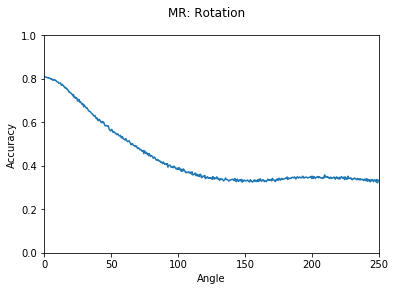

In [11]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

plt.axis([0, 250, 0, 1])
plt.plot(np.arange(0,250,0.5),accMat)
plt.xlabel("Angle")
plt.ylabel("Accuracy")
plt.suptitle("MR: Rotation")
plt.show()

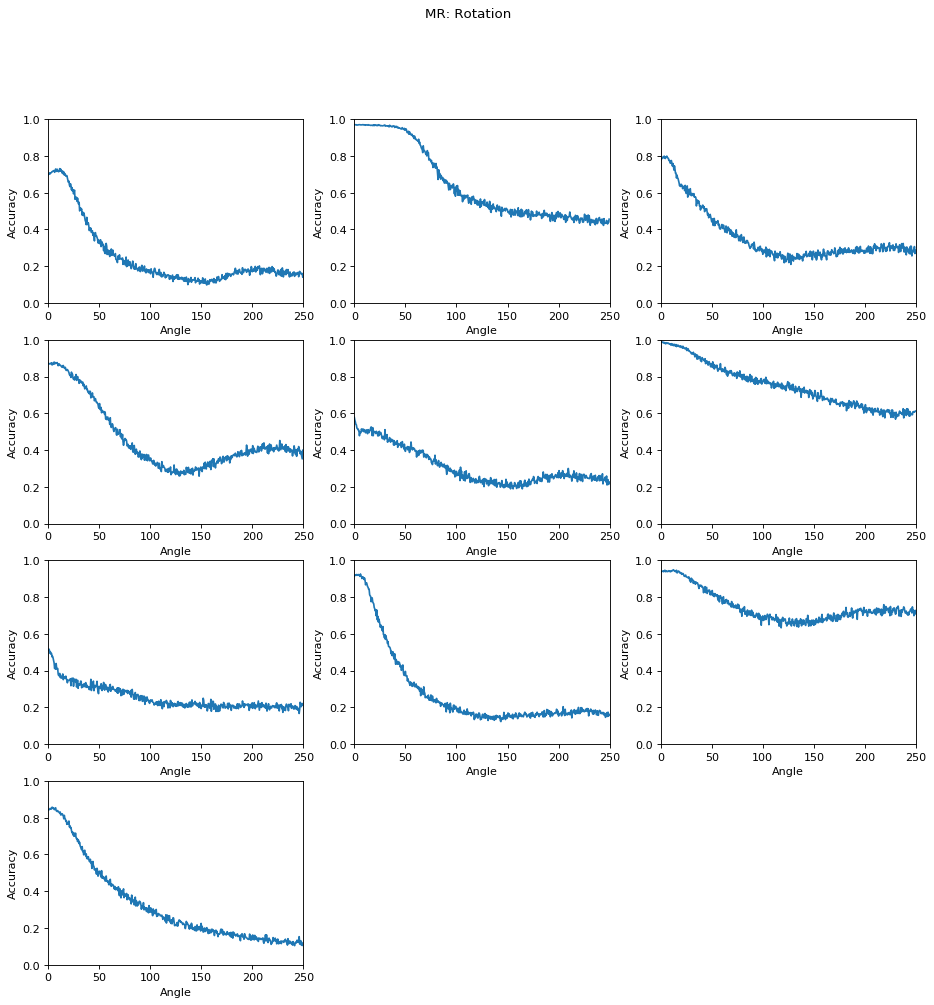

In [12]:
figure(num=None, figsize=(14, 14), dpi=80, facecolor='w', edgecolor='k')

zero = []
for j in range(10):
    zero = []
    for i in range(len(aMatrix)):
        zero.append(aMatrix[i][j][j])
    plt.subplot(4,3,j+1)
    plt.axis([0, 250, 0, 1])
    plt.plot(np.arange(0,250,0.5),zero)
    plt.xlabel("Angle")
    plt.ylabel("Accuracy")
plt.suptitle("MR: Rotation")
plt.show()

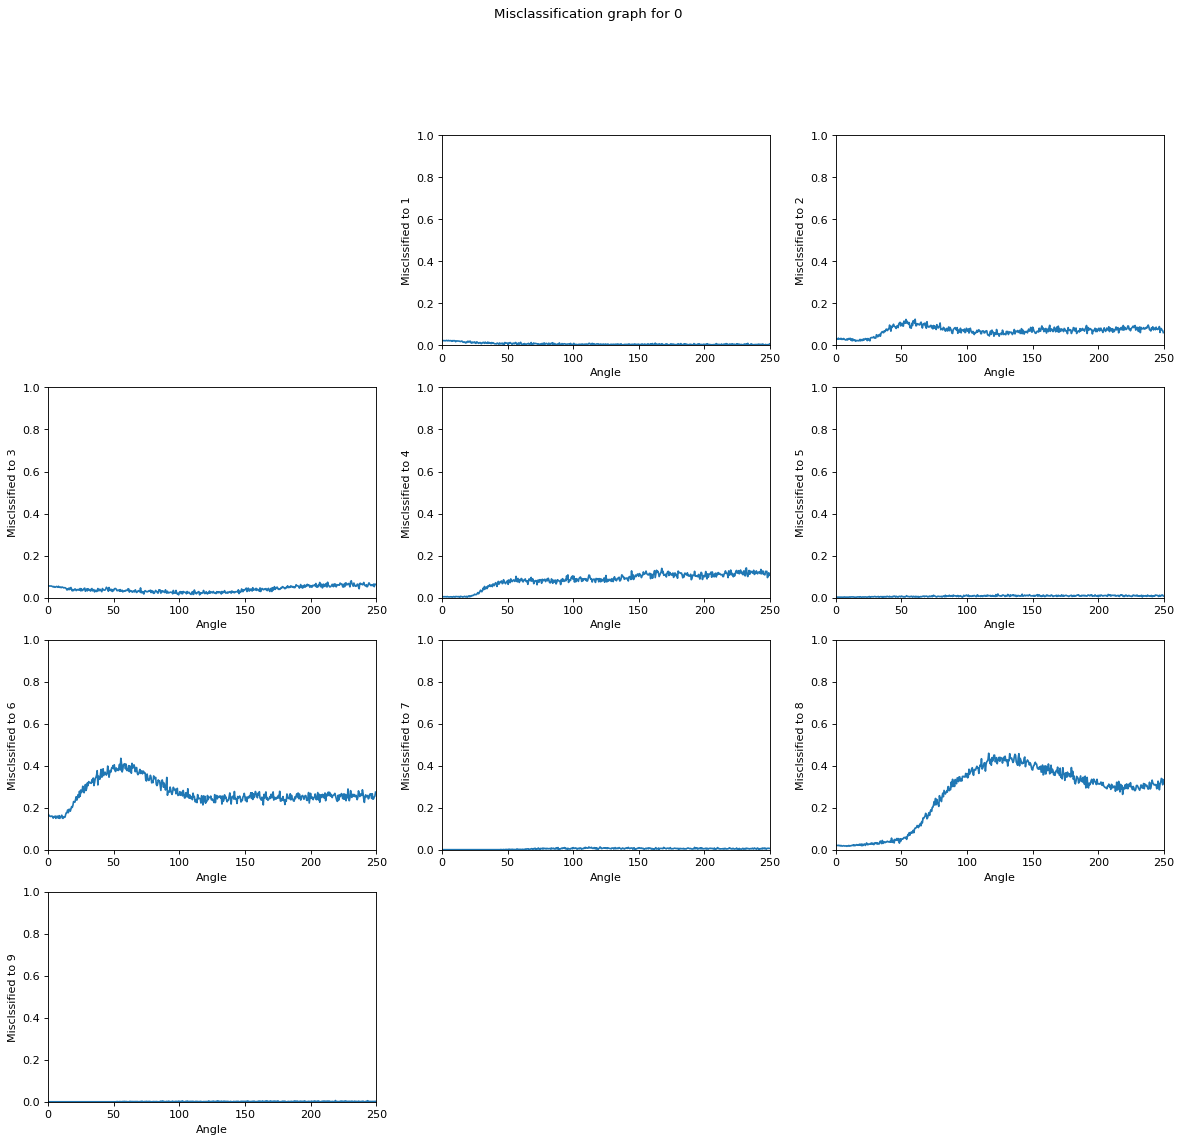

---------------------------------------------------------------------------------------------------------------------


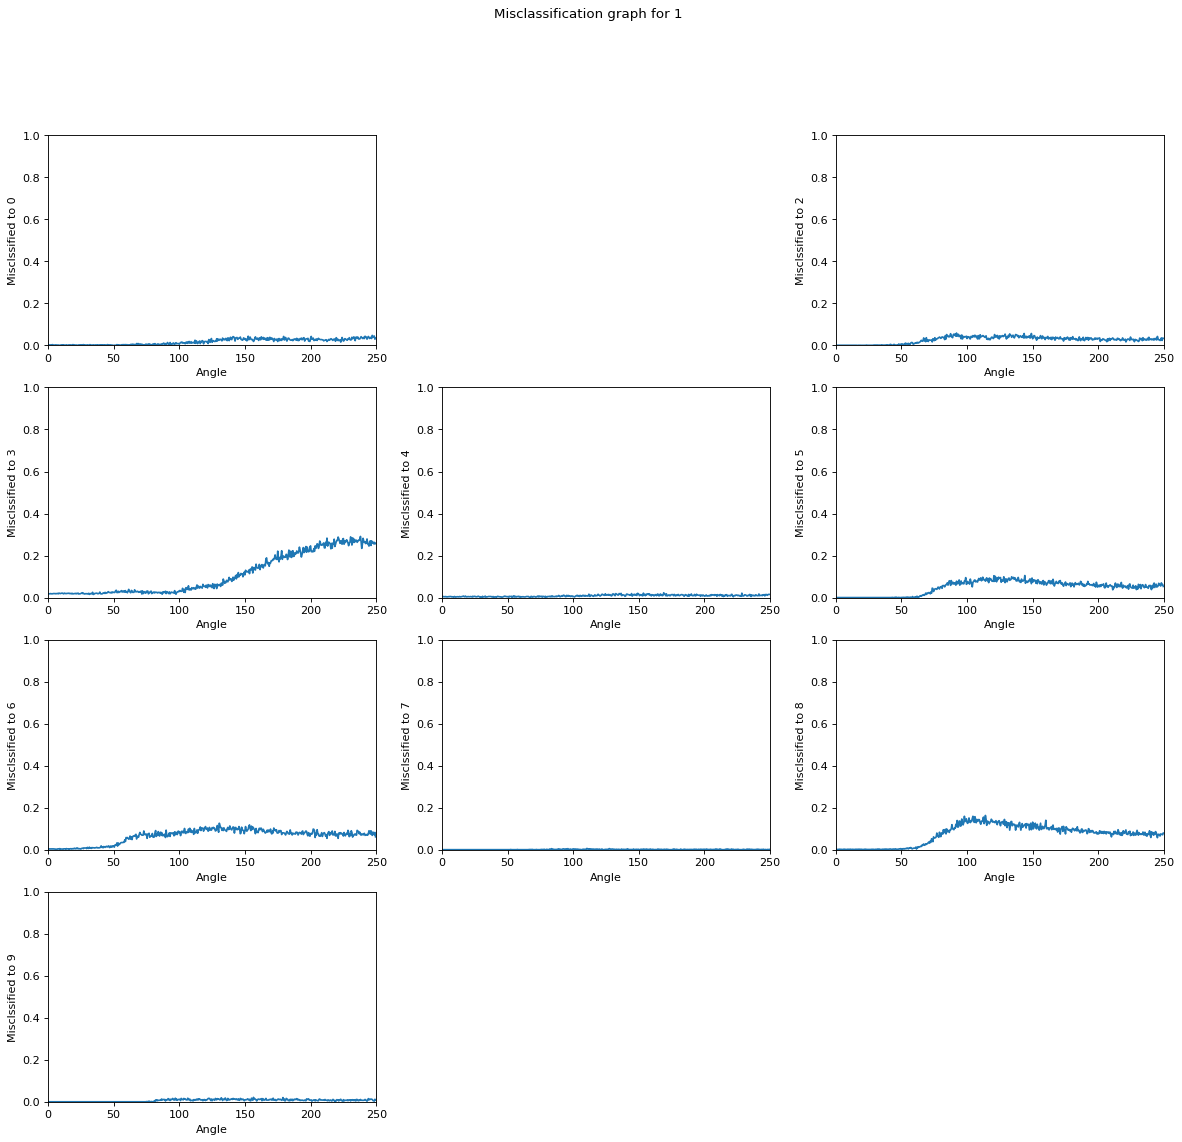

---------------------------------------------------------------------------------------------------------------------


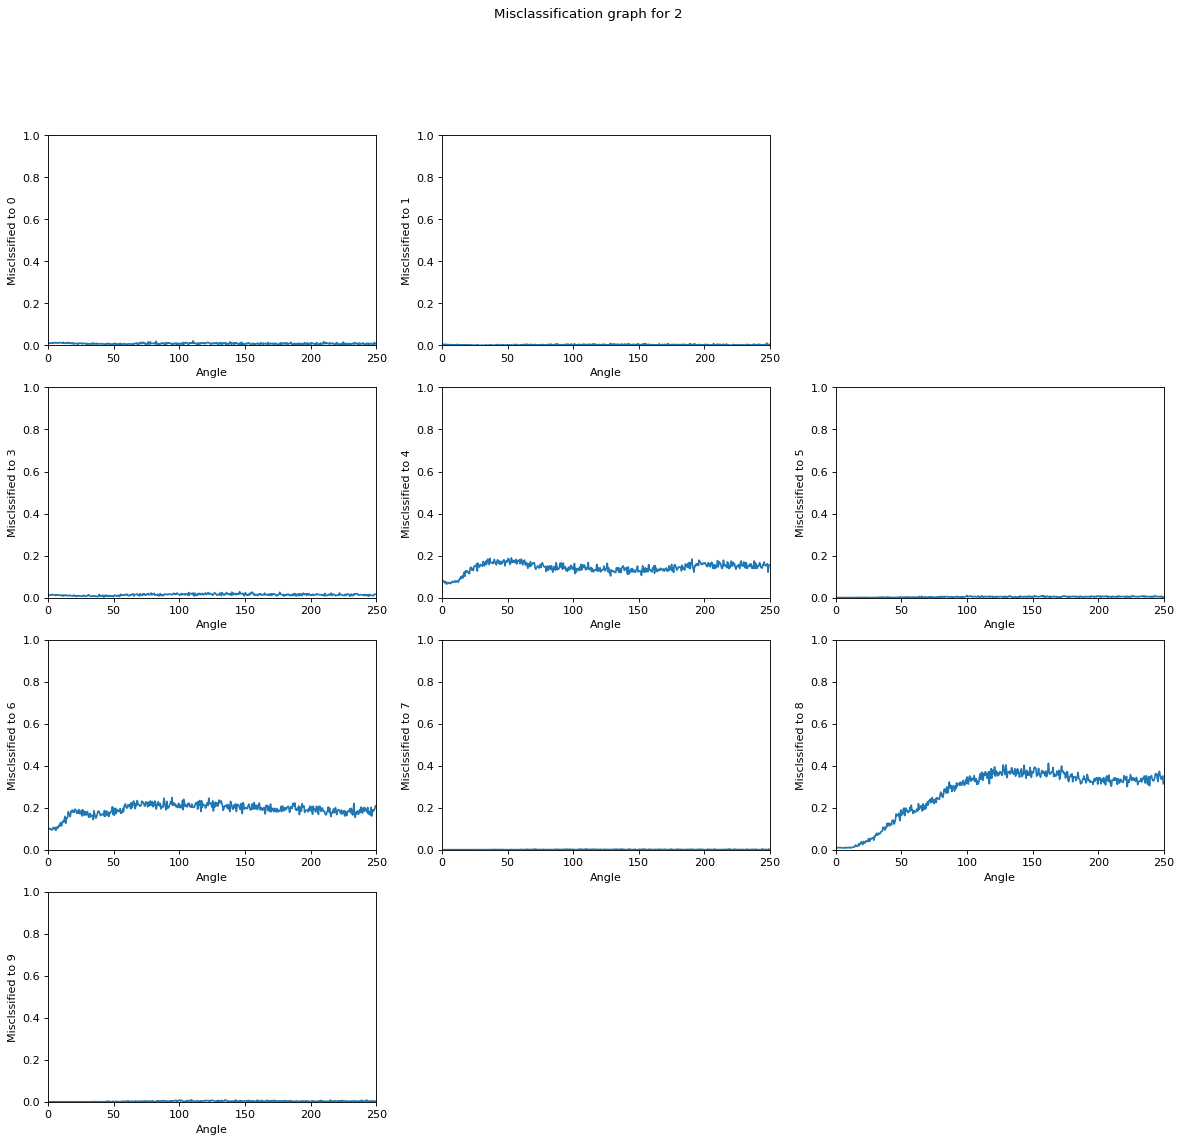

---------------------------------------------------------------------------------------------------------------------


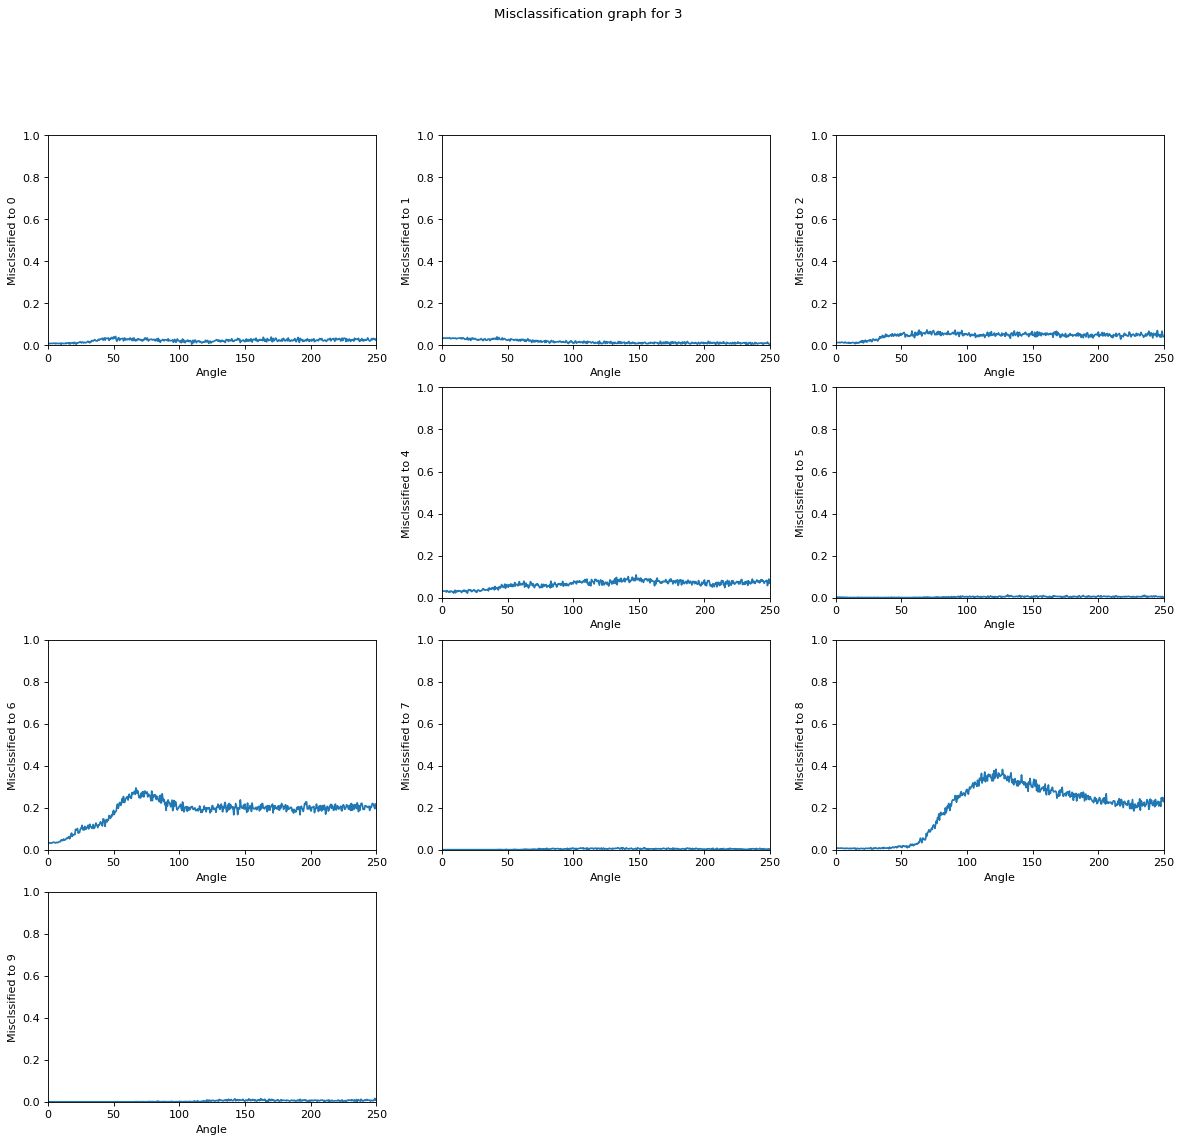

---------------------------------------------------------------------------------------------------------------------


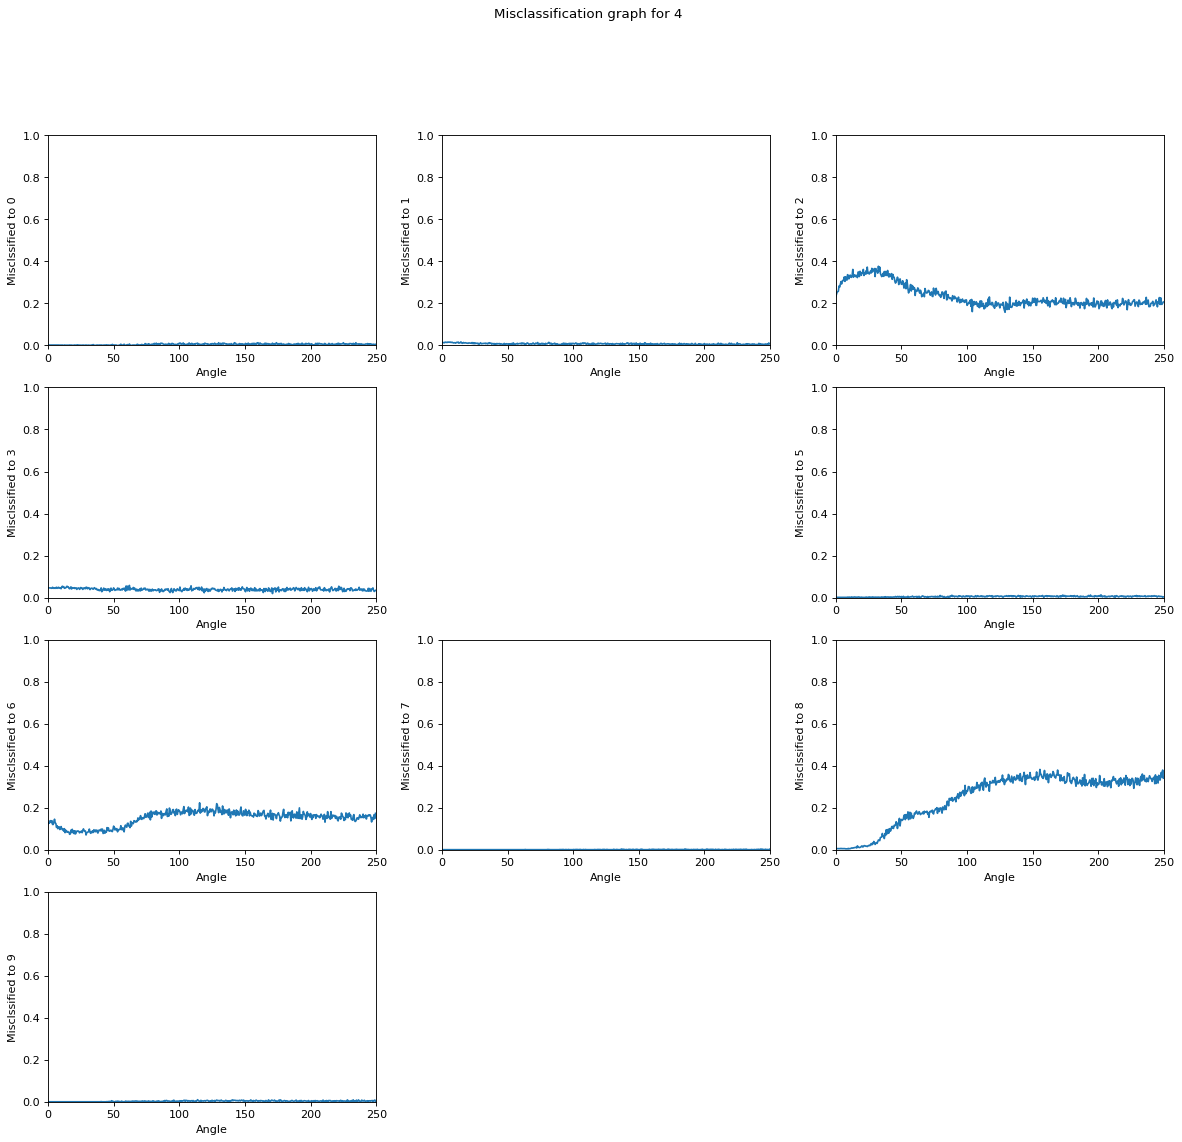

---------------------------------------------------------------------------------------------------------------------


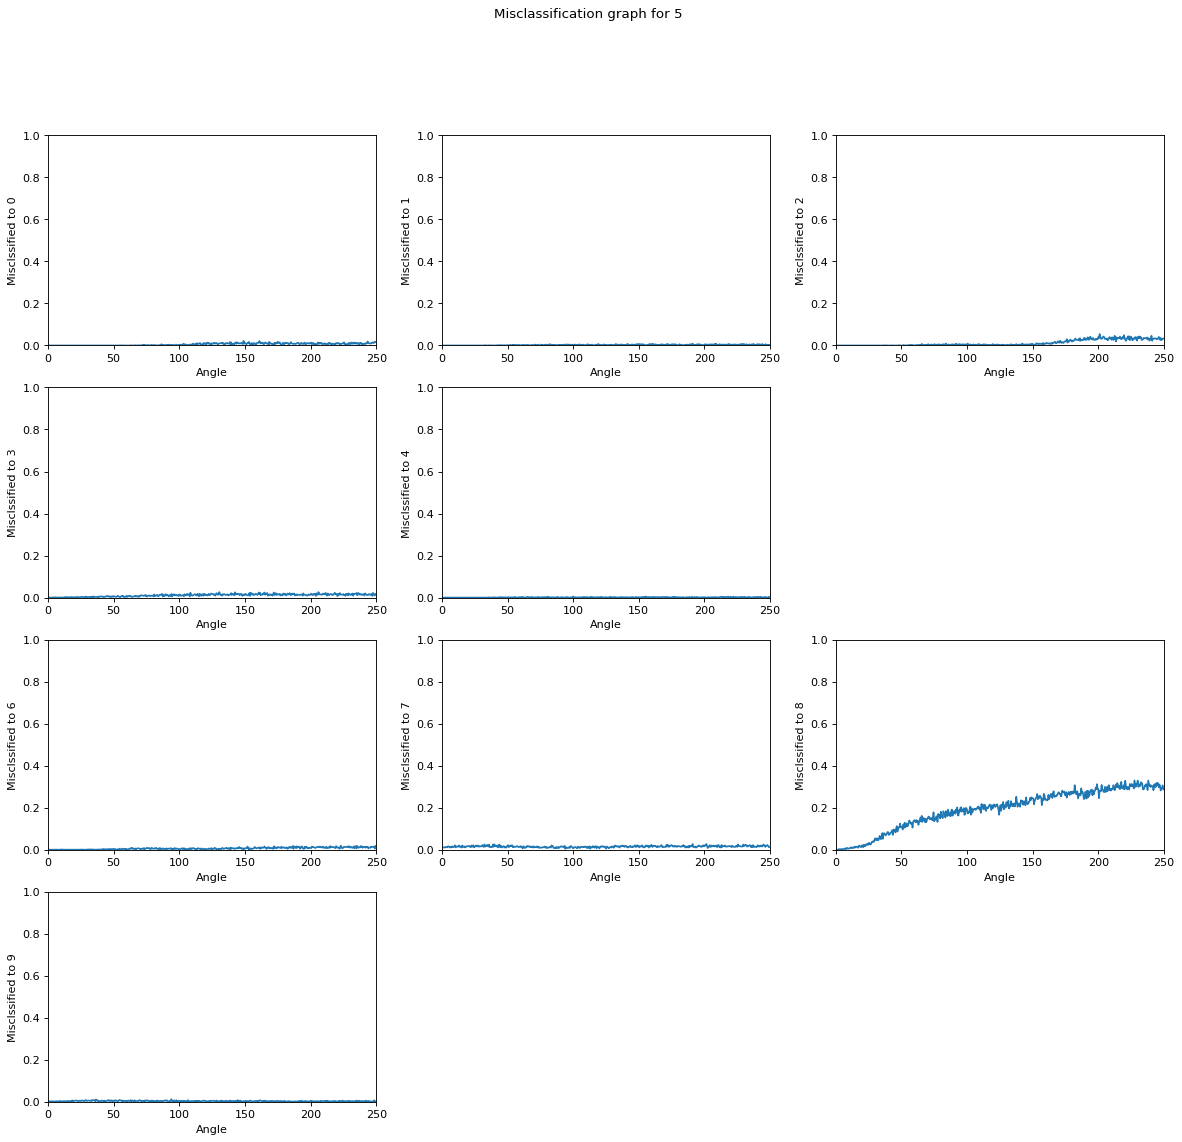

---------------------------------------------------------------------------------------------------------------------


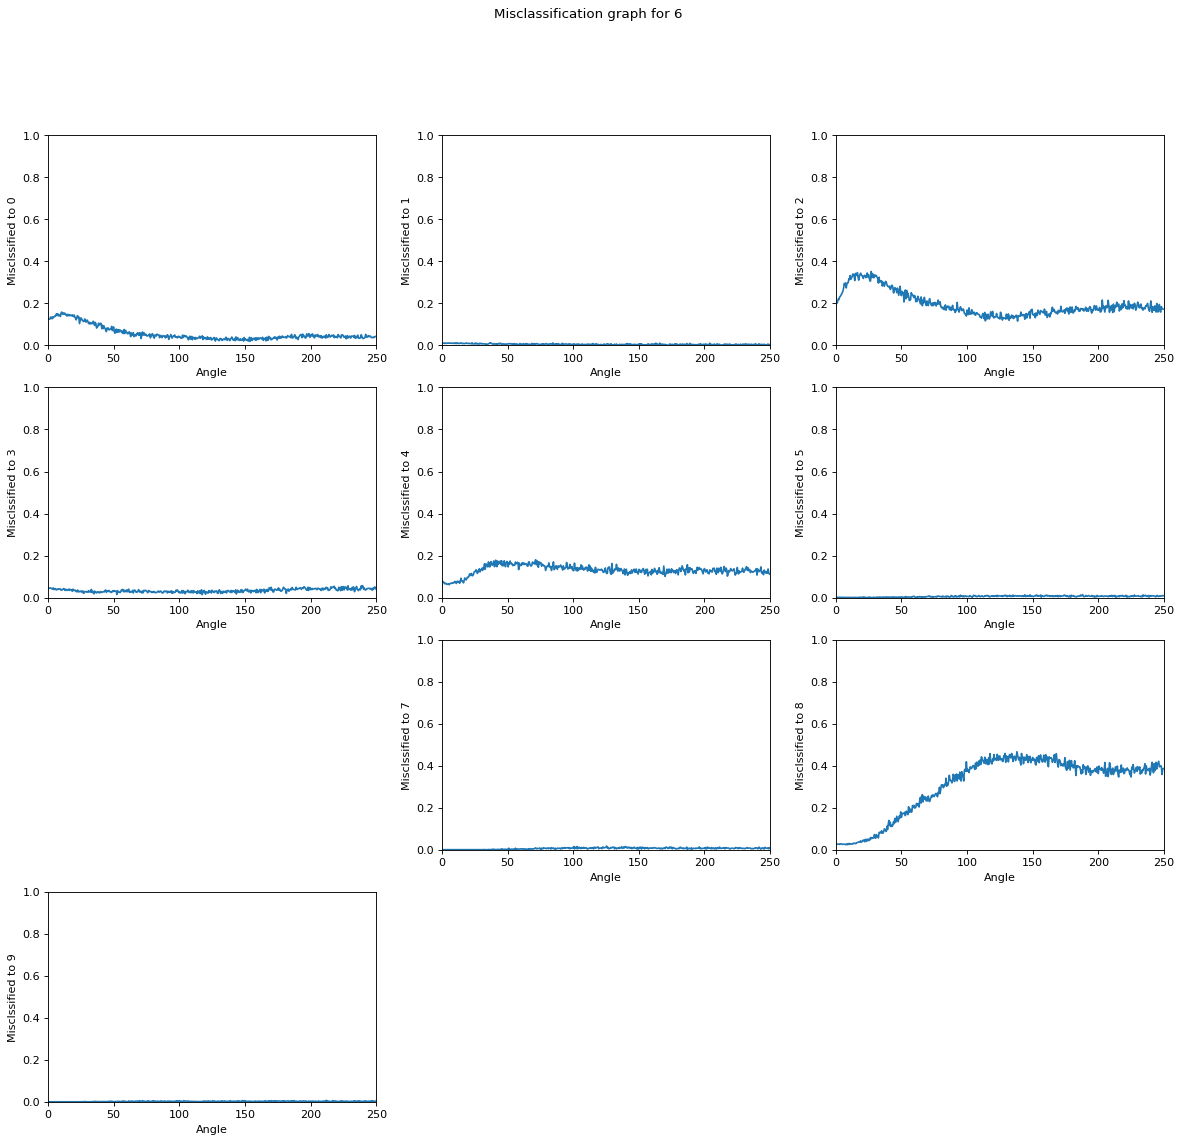

---------------------------------------------------------------------------------------------------------------------


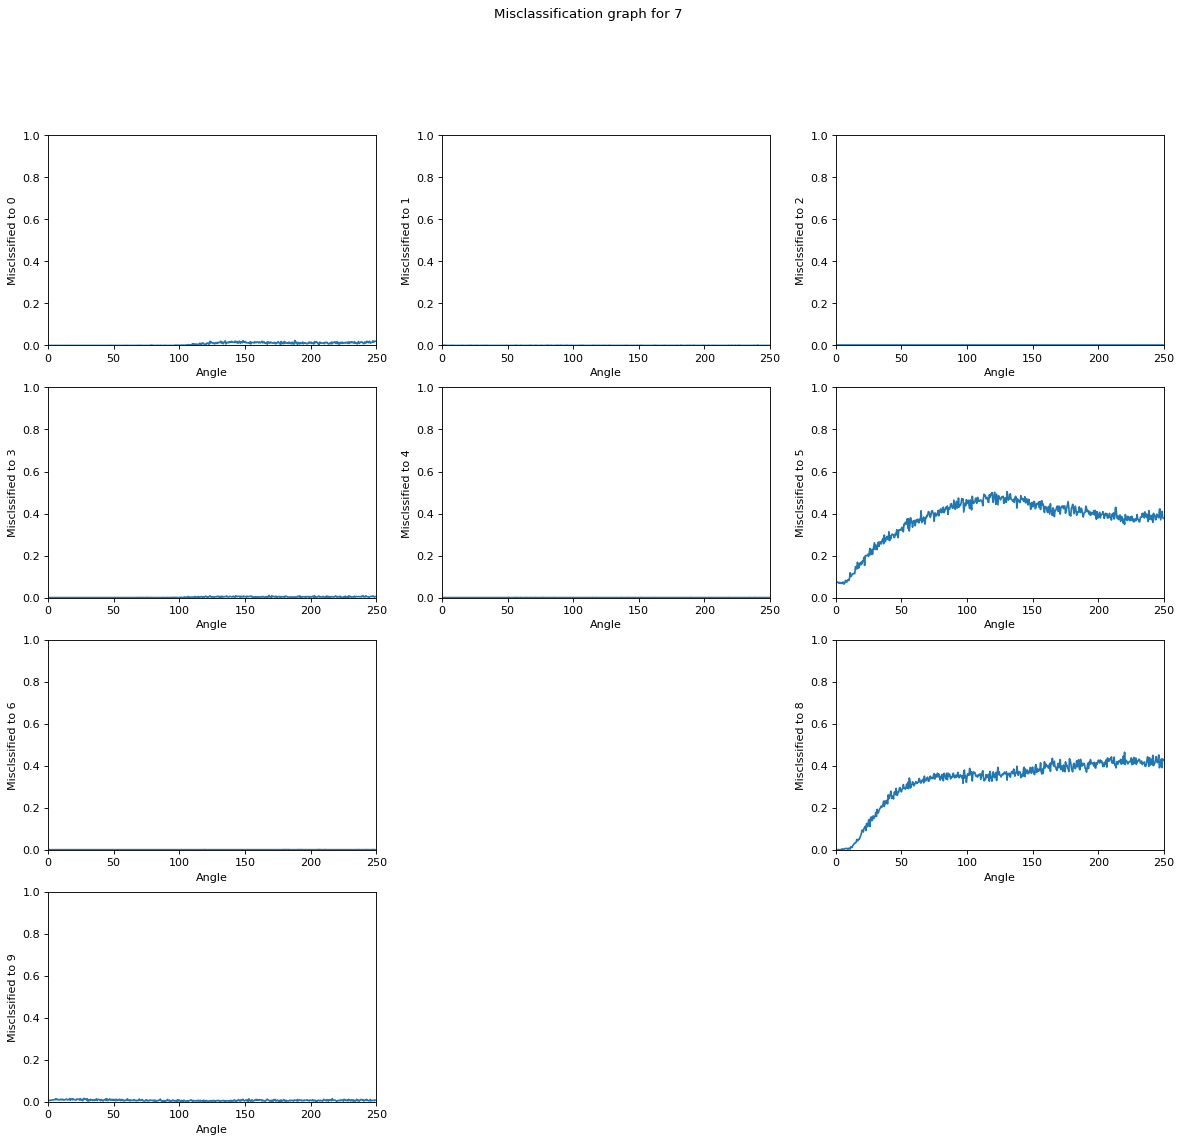

---------------------------------------------------------------------------------------------------------------------


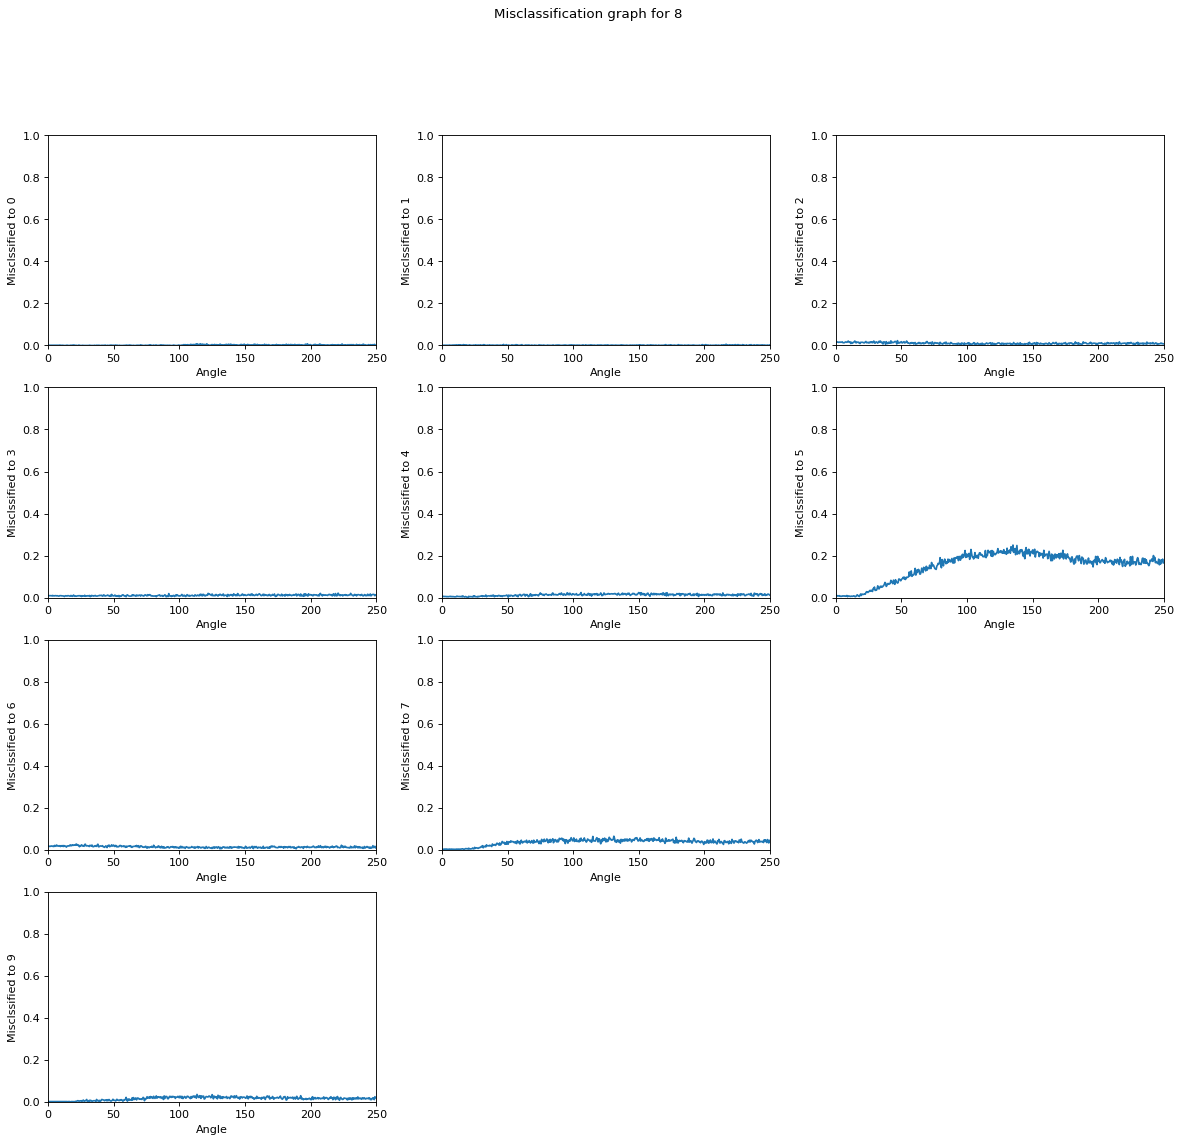

---------------------------------------------------------------------------------------------------------------------


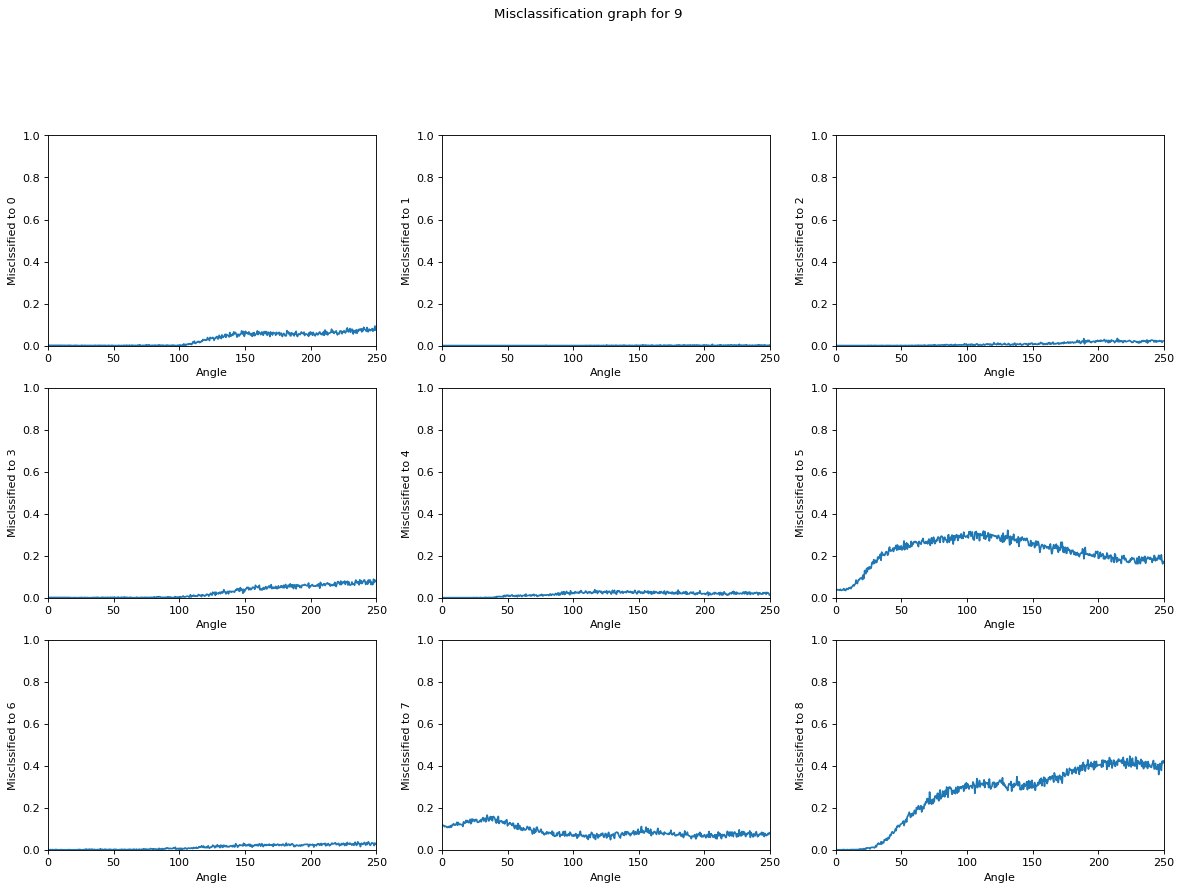

---------------------------------------------------------------------------------------------------------------------


In [13]:
zero = []

for j in range(10):
    figure(num=None, figsize=(18, 16), dpi=80, facecolor='w', edgecolor='k')
    for k in range(0,10):
        zero = []
        if j != k: 
            for i in range(len(aMatrix)):
                zero.append(aMatrix[i][j][k])
        else:
            continue       
        plt.subplot(4,3,k+1)
        plt.axis([0, 250, 0, 1])
        plt.plot(np.arange(0,250,0.5),zero)
        plt.xlabel("Angle")
        plt.ylabel("Misclssified to %s" %str(k))
    plt.suptitle("Misclassification graph for %d" %(j))
    plt.show()
    print("---------------------------------------------------------------------------------------------------------------------")